<a href="https://colab.research.google.com/github/Alisha-Khan-Mridula/Graph-Coloring-Ordering-Prediction-via-Graph-Neural-Network-GNN-/blob/main/Physics_Inspired_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Set up the Environment**
I have used DGL libraries. For successful import of dgl, I have used torch version 2.3.0, and install dgl using command:

!pip install dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html  

I have collected the information and instalation process from DGL official link: https://www.dgl.ai/pages/start.html

In [1]:
import torch
print(torch.__version__)

2.4.1+cu121


In [2]:
!pip uninstall torch -y

Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121


In [1]:
!pip install torch==2.3.0

In [2]:
import torch
print(torch.__version__)

2.3.0+cu121


In [3]:
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.1/355.1 MB 4.7 MB/s eta 0:00:00


In [4]:
#-------------- Necessary imports -------------------
import random
import torch
import warnings
import numpy as np
import networkx as nx
import os
import dgl

from time import time

warnings.filterwarnings('ignore')


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## **Step 0: Load General Utilities Functions**

In [5]:
#------- Known chromatic numbers for specified problems (from references) ---------
chromatic_numbers = {
    # COLOR graphs
    'jean.col': 10,
    'anna.col': 11,
    'huck.col': 11,
    'david.col': 11,
    'homer.col': 13,
    'myciel5.col': 6,
    'myciel6.col': 7,
    'queen5_5.col': 5,
    'queen6_6.col': 7,
    'queen7_7.col': 7,
    'queen8_8.col': 9,
    'queen9_9.col': 10,
    'queen8_12.col': 12,
    'queen11_11.col': 11,
    'queen13_13.col': 13,
    # Citations graphs
    'cora.cites': 5,
    'citeseer.cites': 6,
    'pubmed.cites': 8
}

In [6]:
#----- Setting up seeds ------------

import random
def set_seed(seed):
  """
  Setting seeds for training
  : Seed type: int

  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)



In [7]:
#------------ Getting adjacency matrix of the graph -------------

def get_adjacency_matrix(graph, torch_device, torch_dtype):
  """
  Loading adjacency matrix of the graph

  :param graph: Graph object
  :type of graph: network.OrderedGraph
  :param torch_device: Compute device(GPU or CPU) to map computations
  :type of torch_device: str
  :param torch_dtype: Pytorch datatype to use for matrix
  :type torch_dtype: str
  :return: Adjacency matrix of the graph
  :return type: torch.tensor
  """

  adj_matrix = nx.linalg.graphmatrix.adjacency_matrix(graph).todense() # creating adjacency matrix. Need to know how and differences
  adj_matrix_final = torch.tensor(adj_matrix).type(torch_dtype).to(torch_device)

  return adj_matrix_final


In [8]:
#---------- Parsing the lines from Colored graphs ---------

def parse_lines(lines, node_offset):
  """
  This function will parse lines from the files. "e" denotes an edge between two node. So, it will skip the first character, and return those two nodes.

  :param lines: line to be parsed
  :type lines: str
  :param node_offset: How much to add to count for file numbering
  :type node_off_set: int
  :return: Two nodes of a connected edge (node_from, node_to)
  :return type: int, int
  """

  node_from, node_to = lines.split(' ')[1:] #Skipping the first character as it specifies there is an edge
  node_from, node_to = int(node_from)+node_offset, int(node_to)+node_offset ## nodes in file are 1-indexed, whereas python is 0-indexed

  return node_from, node_to


In [9]:
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import os

from dgl.nn.pytorch import SAGEConv
from dgl.nn.pytorch import GraphConv
from itertools import chain

In [10]:
#-------- Building graphs from colored graphs -------

def building_color_graphs_from_file(file_name, node_offset=-1, file_path=''):
  """
  Load problem definition(graph) from COLOR file (e.g. *.col)

  :param file_name: File name of the color file
  :type file_name: str
  :param node_offset: How much to offset node values contained in file
  :type node_offset: int
  :param file_path: path of the file named 'file_name'
  :type file_path: str
  :return: Graph
  :return type: networkx.OrderedGraph
  """

  fpath = os.path.join(file_path, file_name)
  print(f'Building graph from contents of file: {fpath}')
  with open(fpath, 'r') as f:
    content = f.read().strip()

  # Identify where problem definition starts.
  # All lines prior to this are assumed to be miscellaneous descriptions of file contents
  # which start with "c ".

  start_index = [idx for idx, line in enumerate(content.split('\n')) if line.startswith('p')][0] #The index of the first line in content that starts with the letter 'p'
  lines = content.split('\n')[start_index:]  # skip comment line(s)
  edges = [parse_lines(line, node_offset) for line in lines[1:] if len(line) > 0]

  nx_temp = nx.from_edgelist(edges)

  nx_graph = nx.Graph()
  nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
  nx_graph.add_edges_from(nx_temp.edges)

  return nx_graph



In [11]:
#--------- Graph Sage Class -----------

class GraphSAGE(nn.Module):
  """
  Basic GraphSAGE-based GNN class object. It constraucts model architecture upon initialization, defines a forward step to include revelent parameters,
  in this case just drop out

  """

  def __init__(self, graph, input_features, hidden_size, num_classes, dropout, aggregator_type):
     """
     Initializes the GraphSAGE class. Establishes model architecture and hyperparameters ('dropout', 'num_classes', 'aggregator_type')
     :param graph: Input graph object
     :type graph: dgl.DGLHeteroGraph
     :param input_features: Size of input layers/ number of nodes of input layer
     :type input_features: int
     :param hidden_size: Size of hidden layers
     :type hidden_size: int
     :param num_classes: Size of output layer
     :type num_classes: int
     :param dropout: Dropout fraction, between convolutional layers
     :type dropout: float
     :param aggregator_type: Aggregation type for each graphSAGE layer. In this example, all layers will use the same aggregation types
     :type aggregator_type: str
     """

     super(GraphSAGE, self).__init__()
     self.graph = graph
     self.num_classes = num_classes

     self.layers = nn.Modulelist()

     #input layer
     self.layers.append(SAGEConv(input_features, hidden_size, aggregator_type, activation=F.relu))

     #output layer
     self.layers.append(SAGEConv(hidden_size, num_classes, aggregator_type))
     self.dropout = nn.Dropout(p=dropout)

  def forward(self, features):
    """
    Define forward step of the network. In this example, pass inputs through convolution, activation function relu nad dropout has been applied, then pass through second convolution

    :param features: Input node representations
    :type features: torch.tensor
    :return: Final layer representation, pre-activation(i.e. class logits) Logits = logits refer to the raw, unnormalized output values produced by the last layer of a neural network
             before applying an activation function like softmax or sigmoid.
    :return type: torch.tensor
    """

    h = features
    for i, layer in enumerate(self.layers):
      if i != 0:
        h = self.dropout(h)
      h = layer(self.graph, h)

    return h





In [12]:
# Define GNN GraphConv object
class GNNConv(nn.Module):
    """
    Basic GraphConv-based GNN class object. Constructs the model architecture upon
    initialization. Defines a forward step to include relevant parameters - in this
    case, just dropout.
    """

    def __init__(self, g, in_feats, hidden_size, num_classes, dropout):
        """
        Initialize the model object. Establishes model architecture and relevant hypers (`dropout`, `num_classes`, `agg_type`)

        :param g: Input graph object
        :type g: dgl.DGLHeteroGraph
        :param in_feats: Size (number of nodes) of input layer
        :type in_feats: int
        :param hidden_size: Size of hidden layer
        :type hidden_size: int
        :param num_classes: Size of output layer (one node per class)
        :type num_classes: int
        :param dropout: Dropout fraction, between two convolutional layers
        :type dropout: float
        """

        super(GNNConv, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GraphConv(in_feats, hidden_size, activation=F.relu))
        # output layer
        self.layers.append(GraphConv(hidden_size, num_classes))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features):
        """
        Define forward step of netowrk. In this example, pass inputs through convolution, apply relu
        and dropout, then pass through second convolution.

        :param features: Input node representations
        :type features: torch.tensor
        :return: Final layer representation, pre-activation (i.e. class logits)
        :rtype: torch.tensor
        """

        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        return h

In [13]:
#--------------- Load GNN object, optimizer, and initial embedding layer -------

def get_gnn(graph, num_nodes, gnn_hyperparameters, opt_parameters, torch_device, torch_dtype):
  """
  Helper function to load in GNN object, optimizer, and initial embedding layer

  :param num_nodes: Number of nodes in the graph
  :type num_nodes: int
  :param gnn_hyperparameters: Hyperparameters to provide to GNN constructor
  :type gnn_hyperparameters: dict
  :param opt_parameters: Hyperparameters to provide to optimizer constructor
  :type opt_parameters: dict
  :param torch_device: Compute device(GUP or CPU) to map computations
  :type torch_device: str
  :param torch_dtype: Pytorch datatype to use for matrix
  :type torch_dtype: str
  :return: Initialized GNN instance, embedding layer, initialized optimizer instance
  :return type: GNN_SAGE, torch.nn.Emdedding, torch.optim.AdamW
  """

  try:
    print(f'Function get_gnn(): Setting seed to {gnn_hyperparameters}["seed"]')
    set_seed(gnn_hyperparameters['seed'])
  except KeyError:
     print('!! Function get_gnn(): Seed not specified in gnn_hypers object. Defaulting to 0 !!')
     set_seed(0)

  model = gnn_hyperparameters['model']
  dim_embedding = gnn_hyperparameters['dim_embedding']
  hidden_dim = gnn_hyperparameters['hidden_dim']
  dropout = gnn_hyperparameters['dropout']
  number_classes = gnn_hyperparameters['number_classes']
  aggregator_type = gnn_hyperparameters['layer_agg_type']


  print(f'Building {model} model...')
  if model == 'GraphSAGE':
      net = GraphSAGE(graph, dim_embedding, hidden_dim, number_classes, dropout, aggregator_type )
  elif model == "GraphConv":
      net = GNNConv(graph, dim_embedding, hidden_dim, number_classes, dropout)
  else:
      raise ValueError("Invalid model type input! Model type has to be in one of these two options: ['GraphConv', 'GraphSAGE']")
  net = net.type(torch_dtype).to(torch_device)
  embed = nn.Embedding(num_nodes, dim_embedding).type(torch_dtype).to(torch_device)


  #Setting up Adam optimizer
  params = chain(net.parameters(), embed.parameters())
  print('Building ADAM-W optimizer...')
  optimizer = torch.optim.AdamW(params, **opt_parameters, weight_decay=1e-2)

  return net, embed, optimizer

In [14]:
#---- Calculating loss function -----
def loss_func_mod(probs, adj_tensor):
  """
  Function to compute cost value based on soft assignments (Probabilities)

  :param probs: Probability vector, of each node belonging to each class
  :type probs: torch.tensor
  :param adj_tensor: Adjacency matrix, containing internode weights
  :type adj_tensor: torch.tensor
  :return: loss, given the current soft assignments (probabilities)
  :return type: float
  """
  # probs.T is the transpose of probs
  # (probs @ probs.t) means matrix multiplication in PyTorch. This result will give a matrix where each entry describes the similarity or interaction between pairs of rows from probs
  # This operation can be thought of as weighting the node interactions based on their connectivity in the graph
  #  Divide by 2 to adjust for symmetry about the diagonal (In an undirected graph, edges between nodes are connected twice)

  # Calculating the similarity (dot product) between pairs of node vectors (or probability vectors)
  # Weighting these similarities based on the adjacency matrix (so only connected nodes matter)
  # Summing up these weighted similarities and dividing by 2 to account for symmetric connections

  loss = torch.mul(adj_tensor, (probs @ probs.T)).sum()/2

  return loss

In [15]:
#-------- custom loss according to Q matrix(given colors) -------
def loss_func_color_hard(coloring, nx_graph):
    """
    Function to compute cost value based on color vector (0, 2, 1, 4, 1, ...)

    :param coloring: Vector of class assignments (colors)
    :type coloring: torch.tensor
    :param nx_graph: Graph to evaluate classifications on
    :type nx_graph: networkx.OrderedGraph
    :return: Cost of provided class assignments
    :rtype: torch.tensor
    """

    cost = 0
    for (u, v) in nx_graph.edges:
        cost += 1*(coloring[u] == coloring[v])*(u != v)

    return cost

In [16]:
#--------- GraphSAGE training --------

def run_gnn_training(nx_graph, graph_dgl, adj_mat, net, embed, optimizer, number_epochs=int(1e5), patience=1000, tolerance=1e-4, seed=1 ):
  """
  Function to run model training for given graph, GNN, optimizer, and set of hypers.
  Includes basic early stopping criteria. Prints regular updates on progress as well as
  final decision.

  :param nx_graph: Graph instance to solve
  :param graph_dgl: Graph instance to solve
  :param adj_mat: Adjacency matrix for provided graph
  :type adj_mat: torch.tensor
  :param net: GNN instance to train
  :type net: GNN_Conv or GNN_SAGE
  :param embed: Initial embedding layer
  :type embed: torch.nn.Embedding
  :param optimizer: Optimizer instance used to fit model parameters
  :type optimizer: torch.optim.AdamW
  :param number_epochs: Limit on number of training epochs to run
  :type number_epochs: int
  :param patience: Number of epochs to wait before triggering early stopping
  :type patience: int
  :param tolerance: Minimum change in cost to be considered non-converged (i.e.
      any change less than tolerance will add to early stopping count)
  :type tolerance: float

  :return: Final model probabilities, best color vector found during training, best loss found during training,
  final color vector of training, final loss of training, number of epochs used in training
  :rtype: torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, int
  """

  print(f'Function run_gnn_training(): Setting seed to {seed}')
  set_seed(seed)

  inputs = embed.weight

  # Tracking
  best_cost = torch.tensor(float('Inf'))
  best_loss = torch.tensor(float('Inf'))
  best_coloring = None

  # Early stopping to allow GNN to train to near-completion
  prev_loss = 1 #Initialize loss value(arbitrary)
  count = 0 #track number of times early stopping is triggered

  # Training

  for epoch in range(number_epochs):

    # get soft probability assignments/ output values produced by last layer
    logits = net(inputs)

    # apply softmax normalization
    probs = F.softmax(logits, dim=1)

    # get cost value with POTTS cost function
    loss = loss_func_mod(probs, adj_mat)

    # get cost based on current hard class assignments(coloring)
    # update cost if application
    coloring = torch.argmax(probs, dim=1)
    cost_hard = loss_func_color_hard(coloring, nx_graph)

    if cost_hard < best_cost:
      best_loss = loss
      best_cost = cost_hard
      best_coloring = coloring

    #Early stopping check
    # If loss increases or change in loss is too small, trigger
    if (abs(loss - prev_loss) <= tolerance) | ((loss - prev_loss) > 0):
      count += 1
    else:
      count = 0

    # update loss tracking
    prev_loss = loss

    if count >= patience:
      print(f'Stopping early on epoch {epoch}. Patience count: {count}')
      break

    # run optimizer with backpropagation
    optimizer.zero_grad() #clear gradient for step
    loss.backward() #calculate gradient through compute graph
    optimizer.step() #take step, update weights

    #tracking: print intermediate loss at regular interval
    if epoch % 1000 == 0:
      print('Epoch %d | Soft Loss: %.5f' % (epoch, loss.item()))
      print('Epoch %d | Discrete Cost: %.5f' % (epoch, cost_hard.item()))

  #Print final loss
  print('Epoch %d | Final loss: %.5f' % (epoch, loss.item()))
  print('Epoch %d | Lowest discrete cost: %.5f' % (epoch, best_cost))

  # Final Coloring
  final_loss = loss
  final_coloring = torch.argmax(probs, 1)
  print(f'Final coloring: {final_coloring}, soft loss: {final_loss}')

  return probs, best_coloring, best_loss, final_coloring, final_loss, epoch

In [17]:
# fix seed to ensure consistent results
SEED_VALUE = 0
random.seed(SEED_VALUE)        # seed python RNG
np.random.seed(SEED_VALUE)     # seed global NumPy RNG
torch.manual_seed(SEED_VALUE)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


## **Step 1: Download Data**

In [18]:
# create directory for storing input data

input_data_path = './data/input/COLOR/instances'
if not os.path.exists(input_data_path):
    os.makedirs(input_data_path)

In [19]:
!wget https://mat.tepper.cmu.edu/COLOR/instances/instances.tar -P ./data/input/COLOR/

--2024-10-17 17:13:22--  https://mat.tepper.cmu.edu/COLOR/instances/instances.tar
Resolving mat.tepper.cmu.edu (mat.tepper.cmu.edu)... 128.2.25.179
Connecting to mat.tepper.cmu.edu (mat.tepper.cmu.edu)|128.2.25.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3907584 (3.7M) [application/x-tar]
Saving to: ‘./data/input/COLOR/instances.tar’

instances.tar       100%[===================>]   3.73M  16.3MB/s    in 0.2s    

2024-10-17 17:13:23 (16.3 MB/s) - ‘./data/input/COLOR/instances.tar’ saved [3907584/3907584]



In [20]:
!tar -xvf ./data/input/COLOR/instances.tar -C './data/input/COLOR/instances'

DSJC1000.1.col.b
DSJC1000.5.col.b
DSJC1000.9.col.b
DSJC125.1.col.b
DSJC125.5.col.b
DSJC125.9.col.b
DSJC250.1.col.b
DSJC250.5.col.b
DSJC250.9.col.b
DSJC500.1.col.b
DSJC500.5.col.b
DSJC500.9.col.b
DSJR500.1.col.b
DSJR500.1c.col.b
DSJR500.5.col.b
flat1000_50_0.col.b
flat1000_60_0.col.b
flat1000_76_0.col.b
flat300_20_0.col.b
flat300_26_0.col.b
flat300_28_0.col.b
anna.col
david.col
fpsol2.i.1.col
fpsol2.i.2.col
fpsol2.i.3.col
games120.col
homer.col
huck.col
inithx.i.1.col
inithx.i.2.col
inithx.i.3.col
jean.col
le450_15a.col
le450_15b.col
le450_15c.col
le450_15d.col
le450_25a.col
le450_25b.col
le450_25c.col
le450_25d.col
le450_5a.col
le450_5b.col
le450_5c.col
le450_5d.col
miles1000.col
miles1500.col
miles250.col
miles500.col
miles750.col
mulsol.i.1.col
mulsol.i.2.col
mulsol.i.3.col
mulsol.i.4.col
mulsol.i.5.col
myciel2.col
myciel3.col
myciel4.col
myciel5.col
myciel6.col
myciel7.col
queen10_10.col
queen11_11.col
queen12_12.col
queen13_13.col
queen14_14.col
queen15_15.col
queen16_16.col
queen5

## **Step 2: Setting Up Hyperparameters**

In [21]:
"""
Provided a default set of model hyperparameters. We can modify it
"""

problem_file = 'queen5_5.col'
input_parent = './data/input/COLOR/instances'

In [22]:
# Sample hyperparameters
if TORCH_DEVICE.type == 'cpu':  # example with CPU
    hypers = {
        'model': 'GraphConv',   # set either with 'GraphConv' or 'GraphSAGE'. It cannot take other input
        'dim_embedding': 64,
        'dropout': 0.1,
        'learning_rate': 0.0001,
        'hidden_dim': 64,
        'seed': SEED_VALUE
    }
else:                           # example with GPU
    hypers = {
        'model': 'GraphSAGE',
        'dim_embedding': 77,
        'dropout': 0.3784,
        'learning_rate': 0.02988,
        'hidden_dim': 32,
        'seed': SEED_VALUE
    }

print(hypers)
# Default meta parameters
solver_hypers = {
    'tolerance': 1e-3,           # Loss must change by more than tolerance, or add towards patience count
    'number_epochs': int(5e4),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'layer_agg_type': 'mean',    # How aggregate neighbors sampled within graphSAGE
    'number_classes': chromatic_numbers[problem_file]
}

# Combine into a single set
hypers.update(solver_hypers)
print(hypers)

{'model': 'GraphConv', 'dim_embedding': 64, 'dropout': 0.1, 'learning_rate': 0.0001, 'hidden_dim': 64, 'seed': 0}
{'model': 'GraphConv', 'dim_embedding': 64, 'dropout': 0.1, 'learning_rate': 0.0001, 'hidden_dim': 64, 'seed': 0, 'tolerance': 0.001, 'number_epochs': 50000, 'patience': 500, 'graph_file': 'queen5_5.col', 'layer_agg_type': 'mean', 'number_classes': 5}


### **Step 3: Graph Creation**

In [23]:
# Establish full input location
input_fpath = os.path.join(input_parent, problem_file)
print(input_fpath)

# Load in graph
nx_graph = building_color_graphs_from_file(input_fpath, node_offset=-1, file_path='')

# Get DGL graph from networkx graph
# Ensure relevant objects are placed onto proper torch device
dgl_graph = dgl.from_networkx(nx_graph)
dgl_graph = dgl_graph.to(TORCH_DEVICE)


./data/input/COLOR/instances/queen5_5.col
Building graph from contents of file: ./data/input/COLOR/instances/queen5_5.col


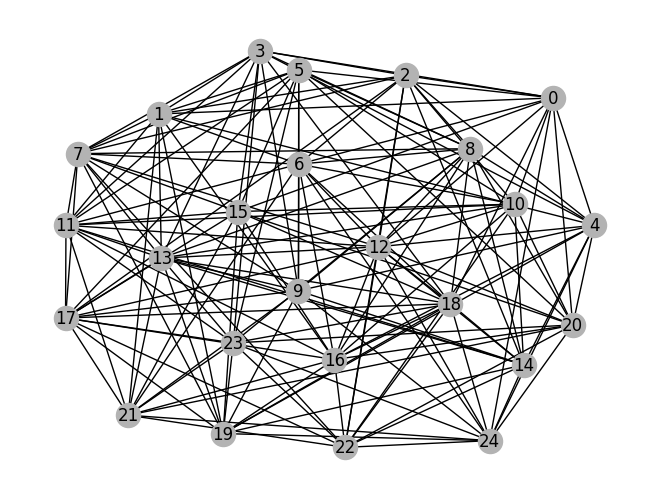

In [24]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

## **Step 4: Setting up Optimizer and GNN Architecture**

In [25]:
# Retrieve known optimizer hypers
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}
print(opt_hypers)

# Get adjacency matrix for use in calculations
adj_ = get_adjacency_matrix(nx_graph, TORCH_DEVICE, TORCH_DTYPE)
#print(adj_)

net, embed, optimizer = get_gnn(dgl_graph, nx_graph.number_of_nodes(), hypers, opt_hypers, TORCH_DEVICE, TORCH_DTYPE)

{'lr': 0.0001}
Function get_gnn(): Setting seed to {'model': 'GraphConv', 'dim_embedding': 64, 'dropout': 0.1, 'learning_rate': 0.0001, 'hidden_dim': 64, 'seed': 0, 'tolerance': 0.001, 'number_epochs': 50000, 'patience': 500, 'graph_file': 'queen5_5.col', 'layer_agg_type': 'mean', 'number_classes': 5}["seed"]
Building GraphConv model...
Building ADAM-W optimizer...


## **Step 5: Training, calculating loss, and calculating chromatic numbers**

In [26]:
t_start = time()

probs, best_coloring, best_loss, final_coloring, final_loss, epoch_num = run_gnn_training(
    nx_graph, dgl_graph, adj_, net, embed, optimizer, hypers['number_epochs'],
    hypers['patience'], hypers['tolerance'], seed=SEED_VALUE)

runtime_gnn = round(time() - t_start, 4)

# report results
print(f'GNN runtime: {runtime_gnn}s')

Function run_gnn_training(): Setting seed to 0
Epoch 0 | Soft Loss: 32.87294
Epoch 0 | Discrete Cost: 160.00000
Epoch 1000 | Soft Loss: 31.92066
Epoch 1000 | Discrete Cost: 21.00000
Epoch 2000 | Soft Loss: 28.51914
Epoch 2000 | Discrete Cost: 25.00000
Epoch 3000 | Soft Loss: 24.79073
Epoch 3000 | Discrete Cost: 20.00000
Epoch 4000 | Soft Loss: 21.68836
Epoch 4000 | Discrete Cost: 17.00000
Epoch 5000 | Soft Loss: 18.77748
Epoch 5000 | Discrete Cost: 17.00000
Epoch 6000 | Soft Loss: 13.72750
Epoch 6000 | Discrete Cost: 3.00000
Epoch 7000 | Soft Loss: 7.45703
Epoch 7000 | Discrete Cost: 0.00000
Epoch 8000 | Soft Loss: 3.65930
Epoch 8000 | Discrete Cost: 0.00000
Epoch 9000 | Soft Loss: 2.11270
Epoch 9000 | Discrete Cost: 0.00000
Epoch 10000 | Soft Loss: 0.81321
Epoch 10000 | Discrete Cost: 0.00000
Epoch 11000 | Soft Loss: 0.54226
Epoch 11000 | Discrete Cost: 0.00000
Epoch 12000 | Soft Loss: 0.28526
Epoch 12000 | Discrete Cost: 0.00000
Epoch 13000 | Soft Loss: 0.15859
Epoch 13000 | Discrete

In [27]:
a_list = final_coloring.tolist()
chromatic_num = max(a_list)+1
print("Chromatic Number:", chromatic_num )



Chromatic Number: 5


In [30]:
# check for color violations
best_cost_hard = loss_func_color_hard(best_coloring, nx_graph)

print(f'Best (hard) cost of coloring (n_class={hypers["number_classes"]}): {best_cost_hard}')

Best (hard) cost of coloring (n_class=5): 0


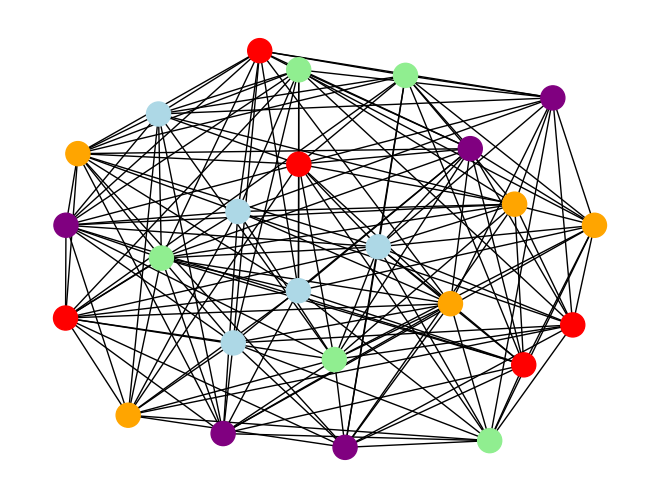

In [29]:
# Visualize result
color_dict = {0:'orange', 1:'lightblue', 2:'purple', 3:'red', 4:'lightgreen'}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)